#  SparseAuxIva - Fast BSS

## Introduction
The cocktail party problem is a situation where multiple people are speaking at the same time and the listener stands back. The percepted signal is not very intelligible, since the words are mixed. Blind Source Separation takes the mixed signal from a few recording devices and demix it to obtain the signals are close as possible to the original speakers. <br>
There are a few different methods to tackle this task, namely Principal Components Analysis (PCA), Independent Component Analysis (ICA) and Independent Vector Analysis (IVA). For this project, we propose an implementation of an optimization of AuxIVA: SparseAuxIva based on Dr. Koldovský paper: 
*A computationally cheaper method for blind speech separation based on auxIVA and incomplete demixing transform.*

## General idea
The proposed method result from the observation that speech is sparse in the frequency domain. We can therefore run the traditionnal separation on selected frequency bins and bring computationnal savings (proportionnal to the number of those selected frequencies). <br>
This yeild to an incomplete demixing transform, but it can be extrapolated through finding its sparsest representation in the time-domain. The latter step is done by using a fast
convex programming algorithm solving LASSO.

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import fftconvolve
import IPython
import pyroomacoustics as pra
from sparseauxiva import sparseauxiva
from scipy.linalg import dft
from sparir import SpaRIR
from pyroomacoustics.bss.common import projection_back
from demix import *
from mir_eval.separation import bss_eval_images

## 0. Signals Generation
First, open and concatanate wav files from the CMU dataset.

In [42]:
# concatanate audio samples to make them look long enough
wav_files = [
        ['../../../examples/input_samples/cmu_arctic_us_axb_a0004.wav',
            '../../../examples/input_samples/cmu_arctic_us_axb_a0005.wav',
            '../../../examples/input_samples/cmu_arctic_us_axb_a0006.wav',],
        ['../../../examples/input_samples/cmu_arctic_us_aew_a0001.wav',
            '../../../examples/input_samples/cmu_arctic_us_aew_a0002.wav',
            '../../../examples/input_samples/cmu_arctic_us_aew_a0003.wav',]
        ]
fs = 16000;

signals = [ np.concatenate([wavfile.read(f)[1].astype(np.float32)
        for f in source_files])
for source_files in wav_files ]

In [43]:
print("Original signal 1 (Woman):")
IPython.display.Audio(signals[0], rate=fs)

Original signal 1 (Woman):


In [44]:
print("Original signal 2 (Man):")
IPython.display.Audio(signals[1], rate=fs)

Original signal 2 (Man):


Define an anechoic room envrionment, as well as the microphone array and source locations.

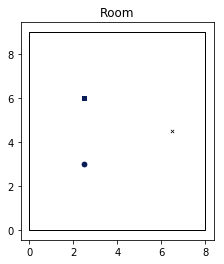

In [45]:
# Room 8m by 9m
room_dim = [8, 9]

# source locations and delays
locations = [[2.5,3], [2.5, 6]]
delays = [1., 0.]

# create an anechoic room with sources and mics
room = pra.ShoeBox(room_dim, fs=16000, max_order=15, absorption=0.35, sigma2_awgn=1e-8)

# add mic and good source to room
# Add silent signals to all sources
for sig, d, loc in zip(signals, delays, locations):
    room.add_source(loc, signal=np.zeros_like(sig), delay=d)

# add microphone array
room.add_microphone_array(pra.MicrophoneArray(np.c_[[6.5, 4.49], [6.5, 4.51]], room.fs))

fig, ax = room.plot()
ax.set_title('Room')

# Compute the RIRs as in the Room Impulse Response generation section.
room.compute_rir()


# Record each source separately
separate_recordings = []
for source, signal in zip(room.sources, signals):

    source.signal[:] = signal

    room.simulate()
    separate_recordings.append(room.mic_array.signals)

    source.signal[:] = 0.
separate_recordings = np.array(separate_recordings)

# Mix down the recorded signals
mics_signals = np.sum(separate_recordings, axis=0)

# Reference signal to calculate performance of BSS
ref = np.moveaxis(separate_recordings, 1, 2)



In [46]:
print("Roomed signal 1:")
IPython.display.Audio(separate_recordings[0], rate=fs)

Roomed signal 1:


In [47]:
print("Roomed signal 2:")
IPython.display.Audio(separate_recordings[1], rate=fs)

Roomed signal 2:


In [48]:
print("Mixed signal:")
IPython.display.Audio(mics_signals[0], rate=fs)

Mixed signal:


## 1. STFT and Bins Selection
In order to have the best performances, we need to choose the frequencies most meaningful to humain speech. Using STFT, we select the bins that have the highest amplitude.

In [49]:
# STFT frame length
L = 2048

# Observation vector in the STFT domain
X = np.array([pra.stft(ch, L, L, transform=np.fft.rfft, zp_front=L//2, zp_back=L//2) for ch in mics_signals])
X = np.moveaxis(X, 0, 2)

# select bins, random or maximum amplitude
ratio = 0.5
average = np.abs(np.mean(np.mean(X, axis=2), axis=0))
k = np.int_(average.shape[0] * ratio)
S = np.argpartition(average, -k)[-k:]
S = np.sort(S)

## 2. AuxIVA on selected bins
Independent Vector Analysis is an extension of ICA to multivariate components, allowing to solve the BBS problem using STFT. Also, the whole frequency components are modeled as a stochastic vector variable and simultaneously processed, avoiding the permutation ambiguity found in other BBS methods (ICA). Here, an auxilary function is prefered from redular gradients for the update rule.

In [50]:
# Run SparseAuxIva
n_iter = 30
Y, W = sparseauxiva(X,S,n_iter, lasso=False, return_filters=True)

Init done, proceeding to sparse AuxIVA...
Successfully computed the sparse weights, proceeding to lasso...


## 3. Interpolation of missing bins

At this point, we have a sparse vector **W** demixing the selected frequency bins in **S**. The goal now is to reconstruct all the weights. If we set 
$$\mathbf{Z}_i = \left[\dfrac{w_{i,1}(k_1)}{w_{i,2}(k_1)}, \ldots,  \dfrac{w_{i,1}(k_{|S|})}{w_{i,2}(k_{|S|})}\right]$$

as the sparse transfer function between the two microphones, the objective function is then
$$ \mathbf{\hat{H}}_{RTF,i} = \arg \underset{\mathbf{H}}{\min} ||\mathbf{Z}_i - \mathbf{H}_S||^2_2 + \mu ||\mathbf{F}^h\mathbf{H}||_1 $$


The regularizer term $\mu ||\mathbf{F}^h\mathbf{H}||_1 $ is justified by fact that relative impulse responses are fast decaying sequences,
 so the RTFs are approximately sparse in the time domain.

Finally, the demixing weight for the frequency bin k is given as 
$$\mathbf{W}(k) = \begin{pmatrix} H_{RTF,2}(k) & -1 \\ H_{RTF,1}(k) & -1 \end{pmatrix}$$

In [51]:
if S[-1] == 2048:
    Sprim = S[0:-1]
else:
    Sprim = S
    
n_frames, n_freq, n_chan = X.shape
k_freq = S.shape[0]
n_src = n_chan

Z = np.zeros((n_src, k_freq), dtype=W.dtype)
G = np.zeros((n_src, n_freq), dtype=Z.dtype)
hrtf = np.zeros((n_freq, n_src), dtype=W.dtype)  # h in the time domain
Hrtf = np.zeros((n_freq, n_src), dtype=W.dtype)  # H in the frequency domain
DFT_matrix = dft(n_freq)
# print(np.all(np.linalg.eigvals(DFT_matrix.T.dot(DFT_matrix)) > 0))
for i in range(n_src):
    Z[i, :] = np.array([W[S[f], 0, i] / W[S[f], 1, i] for f in range(k_freq)]).conj().T
    G[i, S] = Z[i,:]
    hrtf[:-1,i] = SpaRIR(np.expand_dims(G[i,0:-1],axis=1),Sprim)

    Hrtf[:, i] = np.dot(DFT_matrix, hrtf[:, i])
    # Finally, you could assemble W
    for f in range(n_freq):
        W[f, :, i] = np.conj([Hrtf[f, i], 1])

SpaRIR: 9999 iterations done.
SpaRIR: 9999 iterations done.


## 4. Results

**W** is now complete. We now proceed to the final demix. A projection back to the original mixed signal is required to solve the scale ambiguity of AuxIVA. We apply iSTFT to obtain the demixed tracks in time domain and compute SIR and SDR to appreciate the quality of the separation process.  

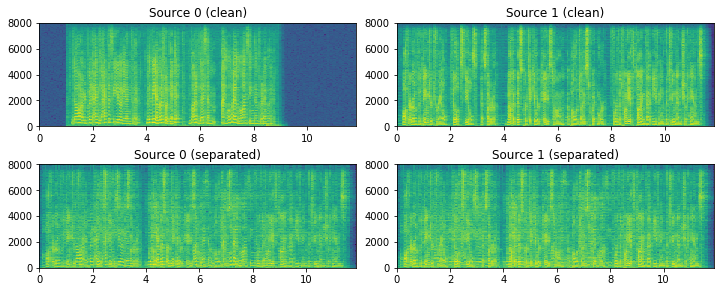

In [52]:
demix(Y, X, np.array(range(n_freq)), W)

# Note: Remember applying projection_back in the end (in ../bss/.common.py) to solve the scale ambiguity
z = projection_back(Y, X[:, :, 0])
Y *= np.conj(z[None, :, :])

# run iSTFT
y = np.array([pra.istft(Y[:,:,ch], L, L, transform=np.fft.irfft, zp_front=L//2, zp_back=L//2) for ch in range(Y.shape[2])])

# Compare SIR and SDR with our reference signal
sdr, isr, sir, sar, perm = bss_eval_images(ref[:,:y.shape[1]-L//2,0], y[:,L//2:ref.shape[1]+L//2])

fig = plt.figure()
fig.set_size_inches(10,  4)

plt.subplot(2,2,1)
plt.specgram(ref[0,:,0], NFFT=1024, Fs=room.fs)
plt.title('Source 0 (clean)')

plt.subplot(2,2,2)
plt.specgram(ref[1,:,0], NFFT=1024, Fs=room.fs)
plt.title('Source 1 (clean)')

plt.subplot(2,2,3)
plt.specgram(y[perm[0],:], NFFT=1024, Fs=room.fs)
plt.title('Source 0 (separated)')

plt.subplot(2,2,4)
plt.specgram(y[perm[1],:], NFFT=1024, Fs=room.fs)
plt.title('Source 1 (separated)')

plt.tight_layout(pad=0.5)

## Comparaison

In [53]:
import time
Times, SIRs = [], []

In [54]:
from sklearn.decomposition import PCA
X_pca = np.moveaxis(mics_signals, 0, 1)
pca = PCA(n_components=2)
start_time = time.time()
h = pca.fit_transform(X_pca)
elapsed_time = time.time() - start_time
Times.append(elapsed_time)
h = np.moveaxis(h, 0, 1)

# Compare SIR and SDR with our reference signal
sdr, isr, sir, sar, perm = bss_eval_images(ref[:,:h.shape[1]-L//2,0], h[:,L//2:ref.shape[1]+L//2])
SIRs.append(sir)

In [55]:
start_time = time.time()
Y = pra.bss.auxiva(X, n_iter=30, proj_back=True)
elapsed_time = time.time() - start_time
Times.append(elapsed_time)
# run iSTFT
y = np.array([pra.istft(Y[:,:,ch], L, L, transform=np.fft.irfft, zp_front=L//2, zp_back=L//2) for ch in range(Y.shape[2])])

# Compare SIR and SDR with our reference signal
sdr, isr, sir, sar, perm = bss_eval_images(ref[:,:y.shape[1]-L//2,0], y[:,L//2:ref.shape[1]+L//2])
SIRs.append(sir)

In [56]:
start_time = time.time()
Y = sparseauxiva(X,S,n_iter, lasso=True)
elapsed_time = time.time() - start_time
Times.append(elapsed_time)
# run iSTFT
y = np.array([pra.istft(Y[:,:,ch], L, L, transform=np.fft.irfft, zp_front=L//2, zp_back=L//2) for ch in range(Y.shape[2])])

# Compare SIR and SDR with our reference signal
sdr, isr, sir, sar, perm = bss_eval_images(ref[:,:y.shape[1]-L//2,0], y[:,L//2:ref.shape[1]+L//2])
SIRs.append(sir)

Init done, proceeding to sparse AuxIVA...
Successfully computed the sparse weights, proceeding to lasso...
SpaRIR: 9999 iterations done.
SpaRIR: 9999 iterations done.
[-0.84+0.j -0.82+0.j]


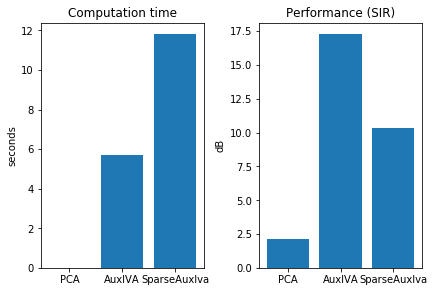

In [57]:
methods = np.arange(3)
plt.figure()
plt.subplot(1,2,1)
plt.bar(methods, Times)
plt.xticks(methods, ('PCA', 'AuxIVA', 'SparseAuxIva'))
plt.title('Computation time')
plt.ylabel('seconds')

plt.subplot(1,2,2)
plt.bar(methods, np.mean(SIRs,axis=1))
plt.xticks(methods, ('PCA', 'AuxIVA', 'SparseAuxIva'))
plt.title('Performance (SIR)')
plt.ylabel('dB')

plt.tight_layout(pad=0.5)